In [8]:
#This Notebook allows for us to optimize the Benchmarking by only transpiling once:
from mqt.bench import get_benchmark
from qiskit import QuantumCircuit, Aer, execute, assemble
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit.compiler import transpile
from qiskit.visualization import plot_gate_map
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt
import numpy as np
import os
import re

#PREFORM SORTING of CIRCUITS:
def sort_circuit(circuits):
    for i in range(len(circuits)):
        min_qubits = circuits[i].num_qubits
        for j in range(len(circuits)):
            temp_qubits = circuits[j].num_qubits
            if min_qubits < temp_qubits:
                min_qubits = temp_qubits
                qc = circuits[i]
                circuits[i] = circuits[j]
                circuits[j] = qc
    
#File Reader Method--> Maybe what we can do is make this method return a map that has a specific optimization level point to a list of circuits. That could work.
def file_reader(file_path):
    backend = FakeSherbrooke()
    circuits = []
    optimization_level= {3: [],2: [], 1: []}
    directory = file_path
    for circuit in os.listdir(directory):
        circuit_path = f"{file_path}/{circuit}"
        if(circuit_path.endswith('.qasm')):
            print(circuit_path)
            qc = QuantumCircuit.from_qasm_file(circuit_path)
            circuits.append(qc)
            
    #Sorts Circuits Before Transpiling:
    sort_circuit(circuits)
        
    counter = 0
    for circuit in circuits:
        qc1 = transpile(circuit, optimization_level= 1, seed_transpiler= 42, backend=backend)
        qc2 = transpile(circuit, optimization_level= 2, seed_transpiler= 42, backend=backend)
        qc3 = transpile(circuit, optimization_level= 3, seed_transpiler= 42, backend=backend)
        optimization_level[1].append(qc1)
        optimization_level[2].append(qc2)
        optimization_level[3].append(qc3)
        print(f"circuit index: {counter} :completed")
        counter = counter + 1
        
    return optimization_level #Returns a Map, that has optimization Level pointing to a list of circuits corresponding to that 

In [56]:
import matplotlib.pyplot as plt
def num_single_and_multi_qubit_gates(circuit):
    Map = {'single' : 0, "multi" : 0}
    for gate in circuit.data:
        if len(gate[1]) == 1:
            Map['single'] = Map['single'] + 1
        else:
            Map['multi'] = Map['multi'] + 1
    return Map

def single_multi_ratio_benchmarking(optimization_levels):
    #These list will store the ratios (single // Multi ) of each circuit
    level1_list = []
    level2_list = []
    level3_list = []    
    return_list = []
    
    for i in range(len(optimization_levels[1])):
        
        level1_data = num_single_and_multi_qubit_gates(optimization_levels[1][i])
        level2_data = num_single_and_multi_qubit_gates(optimization_levels[2][i])
        level3_data = num_single_and_multi_qubit_gates(optimization_levels[3][i])
        
        #Step 3: Prepare ratio and list that contains all the data
        if level1_data['multi'] > 0:
            level1_ratio = level1_data['single'] / level1_data['multi']
            level1_list.append(level1_ratio)
        else:
            level1_list.append(level1_data['single'])
            
        if level2_data['multi'] > 0:
            level2_ratio = level2_data['single'] / level2_data['multi']
            level2_list.append(level2_ratio)
        else:
            level2_list.append(level1_data['single'])
            
        if level3_data['multi'] > 0:
            level3_ratio = level3_data['single'] / level3_data['multi']
            level3_list.append(level3_ratio)
        else:
            level3_list.append(level1_data['single'])
    
        
    return_list.append(level1_list), return_list.append(level2_list), return_list.append(level3_list)
    number_of_circuits = [i + 2 for i in range(len(optimization_levels[1]))]
    
    x = np.array(number_of_circuits)
    
    #Calculating Line of BEST FIT: Optimization Level 1
    a, b = np.polyfit(x, np.array(level1_list), 1)
    #Calculating Line of BEST FIT: Optimization Level 2
    c, d = np.polyfit(x, np.array(level2_list), 1)
    #Calculating Line of BEST Fit: Optimization Lebel 3
    e, f = np.polyfit(x, np.array(level3_list), 1)
    
    #--> Optimization Level 1.. etc lols
    plt.scatter(number_of_circuits, level1_list , label = "Optimization Level 1")    
    plt.plot(x, a*x+b) 
    print("The rate of change for optimization Level 1 is: ", a)
    print("The y-intercept for optimization level 1 is: ", b)
    plt.scatter(number_of_circuits, level2_list, label = "Optimization Level 2")
    plt.plot(x, c*x+d)  
    print("The rate of change for optimization level 2 is: ", c)
    print("The y-intercept for optimization level 2 is: ", d)
    plt.scatter(number_of_circuits, level3_list, label = "Optimization Level 3")
    print("The rate of change for optimization level 3 is: ", e)
    print("The y-intercept for optimization level 3 is: ", f)
    plt.plot(x, e*x+f)  
    plt.title("Transpilation Single Qubit to Multi Qubit gates")
    plt.xlabel('Number of Qubits')
    plt.ylabel('Ratio: (Single | Multi)' )
    plt.legend()
    plt.show()  

The rate of change for optimization Level 1 is:  -0.00038396787924249183
The y-intercept for optimization level 1 is:  4.957780831494213
The rate of change for optimization level 2 is:  -0.0030252369910511332
The y-intercept for optimization level 2 is:  5.043092290345727
The rate of change for optimization level 3 is:  -0.002973761582990351
The y-intercept for optimization level 3 is:  6.9860120842700635


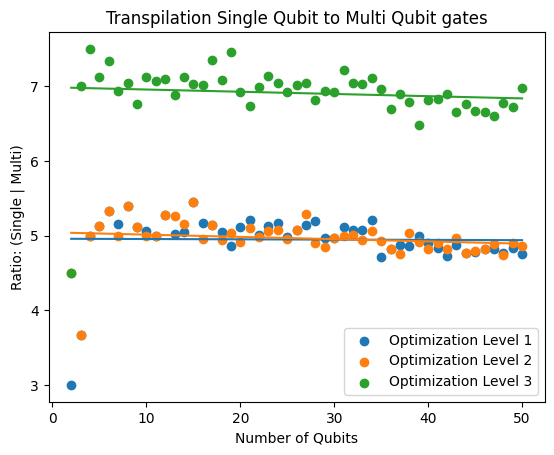

In [57]:
single_multi_ratio_benchmarking(Map)

In [58]:
def gate_count(optimization_levels):
    # Transpile each circuit, count the gates, and store the results
    opt1 = []
    opt2 = []
    opt3 = []
    for i in range(len(optimization_levels[1])):
        # stores the number of gates 

        # counts the number of gates in a given circuit
        opt1_count = optimization_levels[1][i].count_ops()
        opt2_count = optimization_levels[2][i].count_ops()
        opt3_count = optimization_levels[3][i].count_ops()

        # appends our count of the transpiled circuit to the array
        opt1.append(sum(opt1_count.values()))
        opt2.append(sum(opt2_count.values()))
        opt3.append(sum(opt3_count.values()))

    # Generate a graph to visualize the gate counts for optimization level 1
    plt.plot(range(1, len(optimization_levels[1]) + 1), opt1, label = "Optimization Level 1")
    plt.plot(range(1, len(optimization_levels[2]) + 1), opt2, label = "Optimization Level 2")
    plt.plot(range(1, len(optimization_levels[3]) + 1), opt3, label = "Optimization Level 3")
    plt.xlabel('Circuit')
    plt.ylabel('Gate Count')
    plt.title('Gate Count of Transpiled Circuits')
    plt.xticks(range(1, len(optimization_levels[1]) + 1))
    plt.legend()
    plt.show()



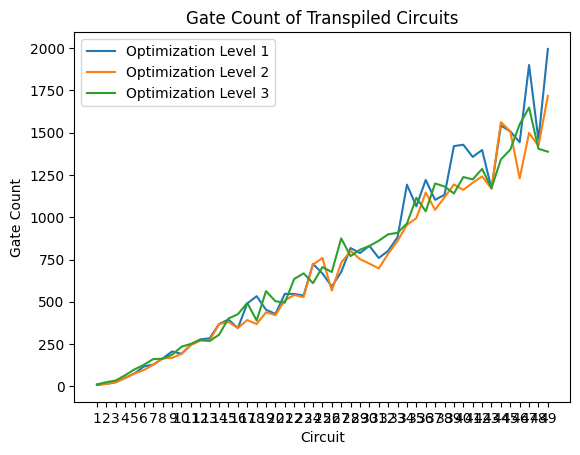

In [59]:
gate_count(Map)